# Assignment 8

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

torch.__version__

'1.2.0'

## Load test data and add noises

In [17]:
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

In [45]:
def activateNoises(imagedata, std_dev):
    noisedata = imagedata + np.random.normal(0, std_dev, imagedata.shape)
    
    noisedata = np.minimum(noisedata, 1)
    noisedata = np.maximum(noisedata, 0)
    
    return noisedata

In [46]:
noises = [0.1, 0.2, 0.3, 0.4]

transform       = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                            ])

# for training
traindata       = np.load('data/train.npy')
traindataset    = numpyDataset(traindata, transform)

noisedata       = activateNoises(traindata, 0.1)
noisedataset    = numpyDataset(noisedata, transform)

trainloader     = DataLoader(traindataset, batch_size=32, shuffle=False, num_workers=0)
noiseloader     = DataLoader(noisedataset, batch_size=32, shuffle=False, num_workers=0)

In [37]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=1, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=1, padding=1),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
        return x

In [47]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(trainloader)
noiseiter = iter(noiseloader)

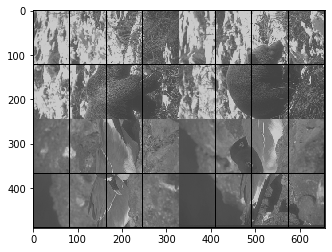

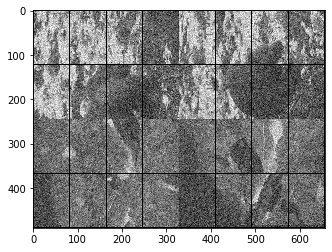

In [53]:
images = trainiter.next()
imshow(torchvision.utils.make_grid(images))

images = noiseiter.next()
imshow(torchvision.utils.make_grid(images))

In [56]:
model = AutoEncoder()

bCuda = 1

if bCuda:
    model.cuda()

optimizer   = optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-5)
objective   = nn.MSELoss()

def train():
    
    loss_train = []
    
    model.train()
    
    trainiter = iter(trainloader)
    
    for idx_batch, data in enumerate(noiseloader):
        
        original = trainiter.next()
        
        if bCuda:
            data = data.cuda()
            original = original.cuda()
        
        data = Variable(data)
        original = Variable(original)

        optimizer.zero_grad()
        output = model(data)
        
        loss = objective(output, original)
        loss.backward()
        optimizer.step()

        loss_train_batch = loss.item()
        loss_train.append(loss_train_batch)
    
    
    loss_train_mean = np.mean(loss_train)
    loss_train_std  = np.std(loss_train)
    
    return {'loss_train_mean': loss_train_mean, 'loss_train_std': loss_train_std }


def test():

    model.eval()
    output  = model(data)

    for idx_batch, (data, target) in enumerate(valloader):

        if bCuda:       
            data, target    = data.cuda(), target.cuda()
        data, target    = Variable(data), Variable(target)

        output  = model(data)
        loss    = objective(output, target)

        loss_test   += loss.item()
        pred        = output.data.max(1)[1]
        correct     += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss_test       = loss_test
    accuracy_test   = 100. * float(correct) / len(valloader.dataset)

    return {'loss_test': loss_test, 'accuracy_test': accuracy_test}
    

In [57]:
NUM_EPOCH = 20

for epoch in trange(NUM_EPOCH):
        
    result_train = train()
    
    print("[epoch %5d] loss: (training) %0.5f " % (epoch+1, result_train['loss_train_mean']))

[epoch     1] loss: (training) 0.01026 
[epoch     2] loss: (training) 0.00279 
[epoch     3] loss: (training) 0.00255 
[epoch     4] loss: (training) 0.00232 
[epoch     5] loss: (training) 0.00219 
[epoch     6] loss: (training) 0.00209 
[epoch     7] loss: (training) 0.00203 
[epoch     8] loss: (training) 0.00212 
[epoch     9] loss: (training) 0.00185 
[epoch    10] loss: (training) 0.00205 
[epoch    11] loss: (training) 0.00180 
[epoch    12] loss: (training) 0.00197 
[epoch    13] loss: (training) 0.00177 
[epoch    14] loss: (training) 0.00192 
[epoch    15] loss: (training) 0.00175 
[epoch    16] loss: (training) 0.00187 
[epoch    17] loss: (training) 0.00174 
[epoch    18] loss: (training) 0.00182 
[epoch    19] loss: (training) 0.00174 
[epoch    20] loss: (training) 0.00179 



In [81]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(trainloader)
noiseiter = iter(noiseloader)

In [88]:
original = trainiter.next()
noises = noiseiter.next()

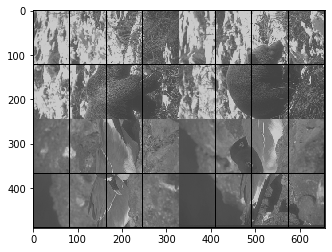

torch.Size([32, 1, 120, 80])


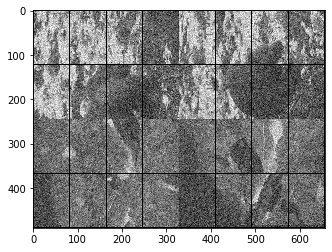

torch.Size([32, 1, 120, 80])


In [89]:
imshow(torchvision.utils.make_grid(original))
print(original.shape)

imshow(torchvision.utils.make_grid(noises))
print(noises.shape)

torch.Size([32, 1, 120, 80])


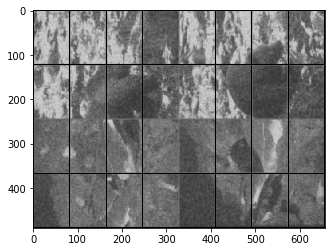

In [90]:
noises = noises.cuda()

output = model(Variable(noises))
print(output.shape)
output = output.cpu().detach()
imshow(torchvision.utils.make_grid(output))